# Sistema Inteligente de Detección de Fraude en Transacciones Financieras

**Objetivo:** Entrenar un modelo de ML que clasifique transacciones como legítimas o fraudulentas.

**Dataset:** Credit Card Fraud Detection (Kaggle)

**Metodología:** CRISP-DM

**Autores:** Oscar Garza, Elizabeth Uresti, Gael Lozano, Adrian Serrato

In [2]:
#Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## 1. Business Understanding

### Problema
El fraude financiero genera pérdidas millonarias. Necesitamos un sistema que detecte transacciones anómalas en tiempo real.

### Métrica clave
**Recall (Sensibilidad):** Queremos capturar el máximo de fraudes posibles, aunque tengamos algunos falsos positivos.

### Objetivo técnico
Entrenar un clasificador con **Recall > 0.85** y **F1-Score > 0.80** en el conjunto de prueba.

In [1]:
import os
if not os.path.exists('data/creditcard.csv'):
    print("Descarga el dataset de Kaggle y colócalo en data/creditcard.csv")
else:
    print("Dataset encontrado")

Dataset encontrado


In [3]:
# Cargar dataset
df = pd.read_csv('data/creditcard.csv')

print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")
df.head()

Dimensiones del dataset: (284807, 31)
Columnas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Estadísticas básicas
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Class
0    284315
1       492
Name: count, dtype: int64

Porcentaje de fraude: 0.17%


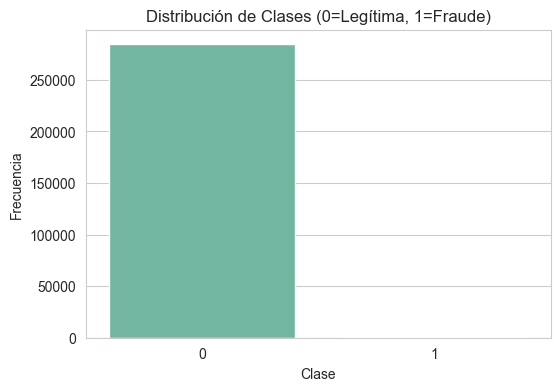

In [6]:
# Distribución de la variable objetivo
class_counts = df['Class'].value_counts()
print(class_counts)
print(f"\nPorcentaje de fraude: {class_counts[1] / len(df) * 100:.2f}%")

# Visualización
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.title('Distribución de Clases (0=Legítima, 1=Fraude)')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

In [7]:
# Verificar valores nulos
print("🔍 Valores nulos por columna:")
print(df.isnull().sum())

🔍 Valores nulos por columna:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


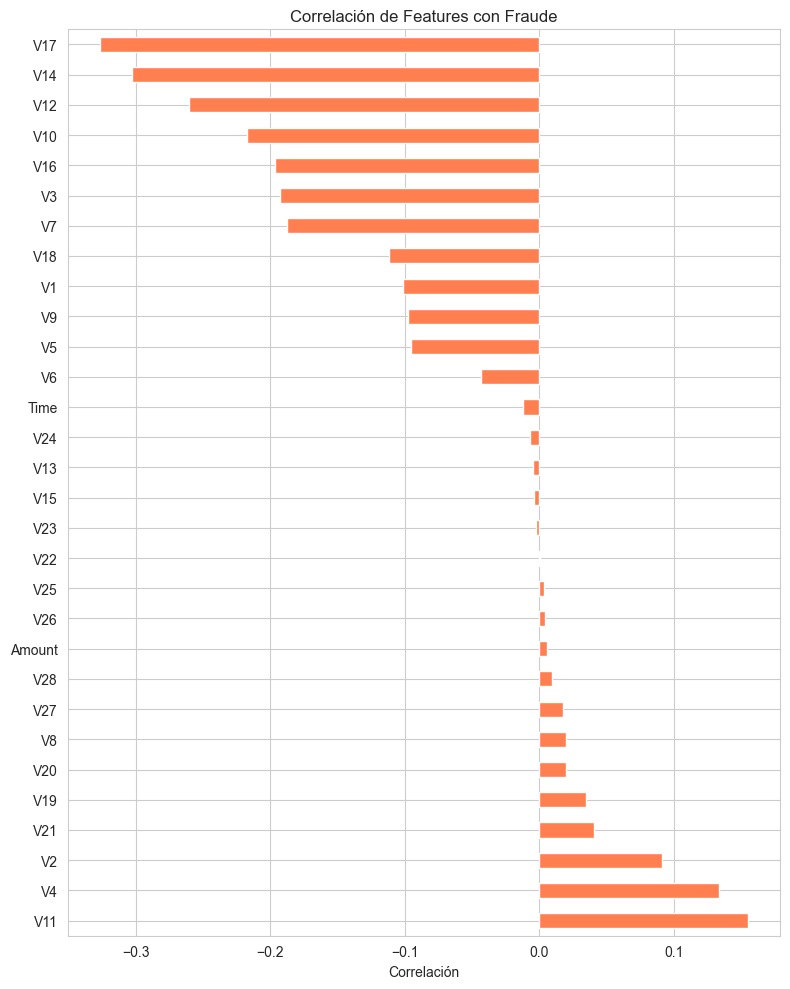

In [8]:
# Correlación de features con Class
correlations = df.corr()['Class'].sort_values(ascending=False)
print(correlations)

# Visualización
plt.figure(figsize=(8, 10))
correlations.drop('Class').plot(kind='barh', color='coral')
plt.title('Correlación de Features con Fraude')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()

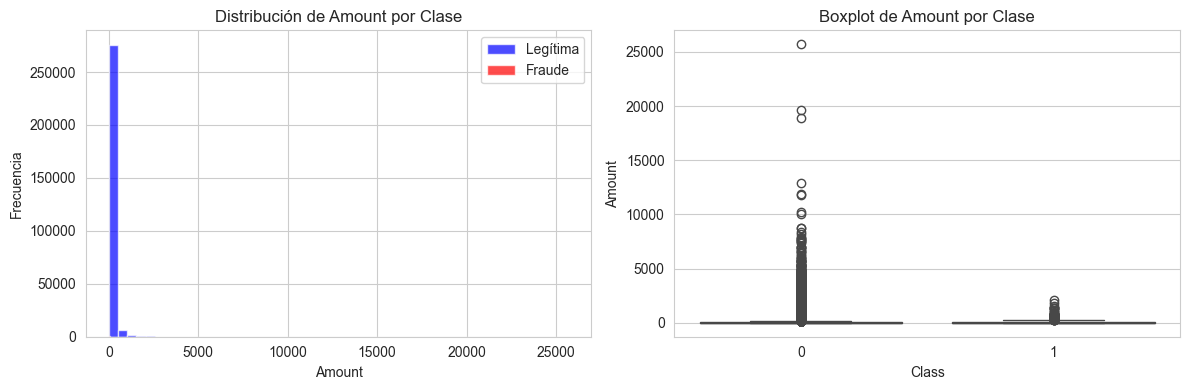

In [9]:
# Distribución de Amount por clase
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df[df['Class'] == 0]['Amount'].hist(bins=50, alpha=0.7, label='Legítima', color='blue')
df[df['Class'] == 1]['Amount'].hist(bins=50, alpha=0.7, label='Fraude', color='red')
plt.xlabel('Amount')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Distribución de Amount por Clase')

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Amount', data=df, palette='Set1')
plt.title('Boxplot de Amount por Clase')

plt.tight_layout()
plt.show()

In [11]:
# Separar features (X) y target (y)
X = df.drop('Class', axis=1)
y = df['Class']

print(f" X shape: {X.shape}")
print(f" y shape: {y.shape}")

 X shape: (284807, 30)
 y shape: (284807,)


In [12]:
from sklearn.preprocessing import StandardScaler

# Escalar Time y Amount (V1-V28 ya están normalizadas por PCA)
scaler = StandardScaler()
X['Time'] = scaler.fit_transform(X[['Time']])
X['Amount'] = scaler.fit_transform(X[['Amount']])

print(" Variables Time y Amount escaladas")
X.head()

 Variables Time y Amount escaladas


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [13]:
from sklearn.model_selection import train_test_split

# Split estratificado (mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f" Train set: {X_train.shape}")
print(f" Test set: {X_test.shape}")
print(f" Fraudes en train: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f" Fraudes en test: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.2f}%)")

 Train set: (227845, 30)
 Test set: (56962, 30)
 Fraudes en train: 394 (0.17%)
 Fraudes en test: 98 (0.17%)


In [14]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f" Train original: {X_train.shape}")
print(f" Train resampled: {X_train_resampled.shape}")
print(f" Distribución después de SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

 Train original: (227845, 30)
 Train resampled: (454902, 30)
 Distribución después de SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64
